<a href="https://colab.research.google.com/github/evan-person/CS5821_PyTorch_Proj1/blob/main/CS5821Proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS5821 Computational Intelligence HW1 Project 
## Evan Lucas



## General Discussion

I took Machine Learning last semester, where we used TensorFlow + Keras for several assignments. Because I wanted a new challenge, I chose to use PyTorch for this assignment.

PyTorch is a bit different from TensorFlow, and I think I prefer the workflow of designing a model in Keras. In the future, I'll go back to Keras, but at least I now can say I've used PyTorch.

I started with a basic image recognition neural net with two convolutional layers and two fully connected layers. I probably made my fully connected layers too large in retrospect and my convolutional layers probably could have handled more filters, but I'm not going to change that at this moment.

Pooling was used after each convolutional layer. Convolutional filters were chosen to be 5x5 because 3x3 seemed too small for some of the thick structures in images and larger seemed like too many parameters (which is silly when I have large fully connected layers). I considered using dropout, but ended up not adding it because I was fairly happy with results.


One other thing that I did that seems strange in retrospect was using the same network, without reinitialization, for both datasets. This doesn't seem like the best usage case (since the images are very different) for transfer learning, but I guess that's what I'm technically doing.

I started using SGD as an optimizer (because I actually understand it), but switched to Adam to try and improve performance. I was familiar with Adam after last semester and it seems to perform well. I didn't see any performance improvement after 10 epochs with the MNIST set, but it may have approached optimimum faster?

One hyperparameter that needed tuning was the learning rate. With 1e-3, FashionMNIST wouldn't train at all. I also played with batch size to try and improve runtime. This led to me having to change my model everytime I wanted to change batch size, which is something that automatically updates in Keras/TF. In particular, the step where you flatten before going into the linear/fully connected layers caused me a bit of a headache.

Coding and processing was done in Google Colab, an online Jupyter implementation. 

Conveniently, both datasets were in the PyTorch dataset repository. Data was normalized to a range of [-1,1], following some PyTorch documentation suggesting that. Because we normalized input data, we were able to use ReLU activation functions, which I selected based on good experiences with them last semester.


I'm pretty happy with my 99% accuracy on MNIST. On Fashion-MNIST, 88% seems acceptable, based on some googling about typical benchmarking of traditional ML methods that give results in the 85%-90% range. There's probably room for improvement, however. If I was going to focus a lot of energy on this project, I'd use Cross Validation to divide the training data and test different model designs to select the model hyperparameters (including numbers of convolutional filters, dropout, fully connected neurons) I would also consider adding another convolutional layer, which would probably require removing a pooling layer or adding padding to my current convolutional layers. 

##Code starts below

First we need to import the necessary PyTorch libraries

In [174]:
#imports will follow pytorch.org tutorial imports as I am using this as an opportunity 
# to get used to PyTorch

#Essential imports
import matplotlib.pyplot as plt
import numpy as np

# PyTorch specific imports
import torch
import torchvision
import torchvision.transforms as transforms

# NN imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Import sklearn confusion matrix and classification report functions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Import seaborn because it makes things pretty

import seaborn as sn

Next we will define the image import transform

In [92]:
# Image import transform
transform = transforms.Compose( #compose combines multiolle image transforms
    [transforms.ToTensor(), #this line converts the image to a tensor
    transforms.Normalize((0.5,), (0.5,))]) #Following suggested normalization to bring into the range of [-1,1] by defining mean and std of 0.5


Load data and define dataloaders

Starting with MNIST dataset

In [129]:

# PyTorch includes MNIST and fasion-MNIST as sample datasets, so we can load this way
trainData = torchvision.datasets.MNIST('./MNIST',
    download=True,
    train=True,
    transform=transform)
testData = torchvision.datasets.MNIST('./MNIST',
    download=True,
    train=False,
    transform=transform)

# Define dataloaders 
# Use a batch size of 4 for now. Could probably go larger later
batchSize = 16 #define as global constant because it comes into play again later
trainloader = torch.utils.data.DataLoader(trainData, batch_size=batchSize,
                                        shuffle=True)


testloader = torch.utils.data.DataLoader(testData, batch_size=batchSize,
                                        shuffle=True)




#Generate labels for classes
classes = range(9)

Look at data dimensions and plot a few images


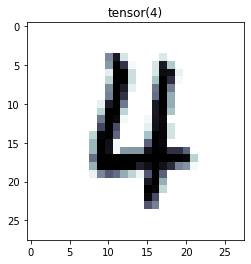

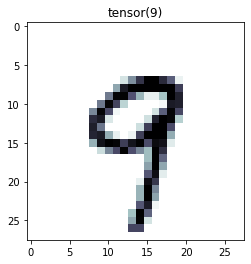

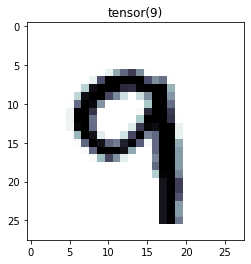

[60000 data points in train set,  10000 data points in test set]


In [128]:
#Plot a couple images
dataiter = iter(trainloader)
images, labels = dataiter.next()

for ii in range(3):
  plt.imshow(images[ii,0,:,:],cmap='bone_r')
  plt.title(labels[ii])
  plt.show()

#print  number of test and training points
print('[%d data points in train set,  %d data points in test set]' % (len(trainData) , len(testData)))

Confirm that we have successfully normalized our data

In [94]:
print(images.max())
print(images.min())

tensor(1.)
tensor(-1.)


Define Neural Net

In [142]:
# Define a net
#Notes, i'm not used to defining a neural net as a class, since I've mostly worked with Keras. 
#If I was a better object oriented programmer, I think I'd enjoy this method more


#Overall structure
#Two 2D convolutional layers, each 5x5 with 16 filters in each
#2x2 max pooling after each conv layer
# Two fully connected layers after the second pooling layer
# One fully connected output layer

#PyTorch defines the structure of the neural net first

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5) #first number is number of channels (colors), second number is number of filters, third number is filter dim
        self.pool = nn.MaxPool2d(2, 2) #2x2 max pooling
        self.conv2 = nn.Conv2d(16, 16, 5) #same as first conv layer, but now we have 16 separate incoming arrays
        self.fc1 = nn.Linear(4*4*batchSize, 120)#Had lots of issues debugging this one, but incoming dimension is 4x4 and you have batchsize
        self.fc2 = nn.Linear(120, 84) #120 neurons may be excessive, as may 84
        self.fc3 = nn.Linear(84, 10) #Need 10 neurons for output layer


#The forward model gets defined separately in PyTorch, which seems weird to me
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #Relu activation
        
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape) #gives me [8,16,4,4], which is batch, channels, height, width
        x = x.view(-1, 4*4*batchSize) #This doesn't seem correct, but I guess this is how I'm supposed to reshape to flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = self.fc3(x)
        #print(x.shape)
        return x


net = Net()

Define optimizer and loss function

In [146]:
lossFn = nn.CrossEntropyLoss() 

# Start with SGD because it's easy to understand. Maybe go with Adam later if that's available in PyTorch
#optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
#Update to Adam, given experience in ML class last semester
optimizer = optim.Adam(net.parameters(), lr = 0.001)

Create a loop to train the neural net

I could have also included some dropout layers, but this doesn't seem to be necessary at this time.


In [152]:
nEpochs = 20 #Started with 20, probably don't need that many
for epoch in range(nEpochs):
  runningLoss = 0.0 #create running total of loss so we can compare between epochs
  for i, data in enumerate(trainloader,0): #loop through all data
    inputs, labels = data #load data
    optimizer.zero_grad() #need to set gradients to zero before we do backpropagation
    outputs = net(inputs) #calc forward model
    #print(outputs)
    loss = lossFn(outputs, labels) #calc loss between actual and predicted
    loss.backward() # calculated gradient
    optimizer.step() # update based on calculated gradient

    runningLoss += loss.item() #combine loss with previous loss
    
  print('Epoch: %d, Loss: %.3f' % (epoch +1, runningLoss/i)) #show loss normalized by number of batches
  

print('done')

Epoch: 1, Loss: 0.017
Epoch: 2, Loss: 0.017
Epoch: 3, Loss: 0.015
Epoch: 4, Loss: 0.014
Epoch: 5, Loss: 0.012
Epoch: 6, Loss: 0.012
Epoch: 7, Loss: 0.014
Epoch: 8, Loss: 0.012
Epoch: 9, Loss: 0.012
Epoch: 10, Loss: 0.012
Epoch: 11, Loss: 0.010
Epoch: 12, Loss: 0.012
Epoch: 13, Loss: 0.011
Epoch: 14, Loss: 0.009
Epoch: 15, Loss: 0.012
Epoch: 16, Loss: 0.009
Epoch: 17, Loss: 0.011
Epoch: 18, Loss: 0.009
Epoch: 19, Loss: 0.011
Epoch: 20, Loss: 0.009
done


Make a couple predictions and look at them

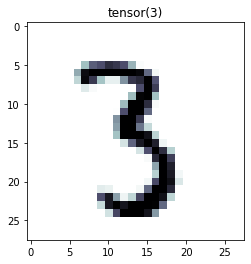

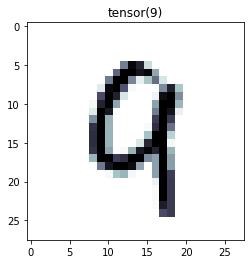

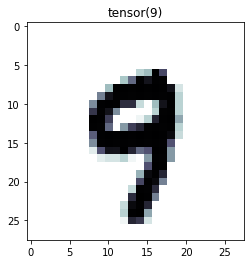

In [156]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(images)

_, predicted = torch.max(outputs, 1)




for ii in range(3):
  plt.imshow(images[ii,0,:,:],cmap='bone_r')
  plt.title(predicted[ii])
  plt.show()


Load the full test set and evaluate test results

In [166]:
trueLabels = []; #initialize empty arrays to store true labels and predicted labels
predLabels = [];
with torch.no_grad(): #This tells PyTorch not to do gradient calculation during evaluation
    for data in testloader: #iterate through data
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) #have to take the max to get the predicted class
        trueLabels = np.concatenate((trueLabels,labels)) #concatenate results
        predLabels = np.concatenate((predLabels,predicted))


In [164]:
print(trueLabels.shape) #Just making sure all the data is there

(10000,)


Generate a confusion matrix and view it

Also generate a report



              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       980
         1.0       0.99      0.99      0.99      1135
         2.0       0.99      0.99      0.99      1032
         3.0       0.99      0.98      0.99      1010
         4.0       0.99      0.99      0.99       982
         5.0       0.99      1.00      0.99       892
         6.0       0.99      0.99      0.99       958
         7.0       0.99      0.98      0.98      1028
         8.0       0.99      0.99      0.99       974
         9.0       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



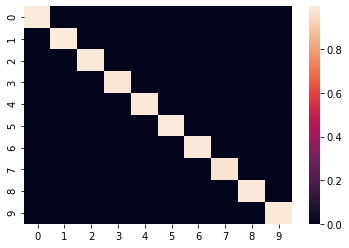

In [175]:
cmat = confusion_matrix(trueLabels, predLabels,normalize = 'true')
sn.heatmap(cmat)

print(classification_report(trueLabels, predLabels))


99% accuracy, yay!


###On to Fashion MNIST!!

Load the data

In [184]:
#Classes are copied from an example, there may be errors, but they seem OK
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Load datasets
trainData = torchvision.datasets.FashionMNIST('./fashionMNIST',
    download=True,
    train=True,
    transform=transform)
testData = torchvision.datasets.FashionMNIST('./fashionMNIST',
    download=True,
    train=False,
    transform=transform)

# Specify dataloaders
trainloader = torch.utils.data.DataLoader(trainData, batch_size=batchSize,
                                        shuffle=True)


testloader = torch.utils.data.DataLoader(testData, batch_size=batchSize,
                                        shuffle=True)

Let's check out some of the images

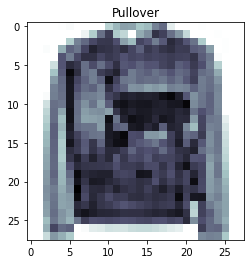

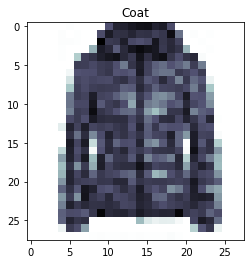

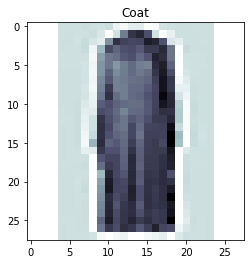

[60000 data points in train set,  10000 data points in test set]


In [205]:
#Plot a couple images
dataiter = iter(trainloader)
images, labels = dataiter.next()

for ii in range(3):
  plt.imshow(images[ii,0,:,:],cmap='bone_r')
  plt.title(classes[labels[ii]])
  plt.show()

#print  number of test and training points
print('[%d data points in train set,  %d data points in test set]' % (len(trainData) , len(testData)))

Need to update my optimizer due to a too high learning rate

In [177]:
lossFn = nn.CrossEntropyLoss() 

# Using Adam after previous success. Turning lr down an order of magnitude after early bad results
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

I really should have put this into a function, but I made it this far and I'm too lazy to go back and do that.

In [195]:
nEpochs = 20 
for epoch in range(nEpochs):
  runningLoss = 0.0 #create running total of loss so we can compare between epochs
  for i, data in enumerate(trainloader,0): #loop through all data
    inputs, labels = data #load data
    optimizer.zero_grad() #need to set gradients to zero before we do backpropagation
    outputs = net(inputs) #calc forward model
    #print(outputs)
    loss = lossFn(outputs, labels) #calc loss between actual and predicted
    loss.backward() # calculated gradient
    optimizer.step() # update based on calculated gradient

    runningLoss += loss.item() #combine loss with previous loss
    
  print('Epoch: %d, Loss: %.3f' % (epoch +1, runningLoss/i)) #show loss normalized by number of batches
  

print('done')

Epoch: 1, Loss: 0.350
Epoch: 2, Loss: 0.338
Epoch: 3, Loss: 0.327
Epoch: 4, Loss: 0.317
Epoch: 5, Loss: 0.308
Epoch: 6, Loss: 0.299
Epoch: 7, Loss: 0.291
Epoch: 8, Loss: 0.284
Epoch: 9, Loss: 0.276
Epoch: 10, Loss: 0.270
Epoch: 11, Loss: 0.264
Epoch: 12, Loss: 0.257
Epoch: 13, Loss: 0.252
Epoch: 14, Loss: 0.247
Epoch: 15, Loss: 0.241
Epoch: 16, Loss: 0.236
Epoch: 17, Loss: 0.232
Epoch: 18, Loss: 0.227
Epoch: 19, Loss: 0.222
Epoch: 20, Loss: 0.218
done


Evaluate model 

In [196]:
trueLabels = []; #initialize empty arrays to store true labels and predicted labels
predLabels = [];
with torch.no_grad(): #This tells PyTorch not to do gradient calculation during evaluation
    for data in testloader: #iterate through data
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) #have to take the max to get the predicted class
        trueLabels = np.concatenate((trueLabels,labels)) #concatenate results
        predLabels = np.concatenate((predLabels,predicted))


In [197]:
print(trueLabels.shape) #Just making sure all the data is there

(10000,)


              precision    recall  f1-score   support

 T-shirt/top       0.81      0.84      0.82      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.78      0.80      0.79      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.80      0.79      0.79      1000
      Sandal       0.97      0.96      0.96      1000
       Shirt       0.70      0.65      0.67      1000
     Sneaker       0.94      0.94      0.94      1000
         Bag       0.96      0.96      0.96      1000
  Ankle Boot       0.95      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



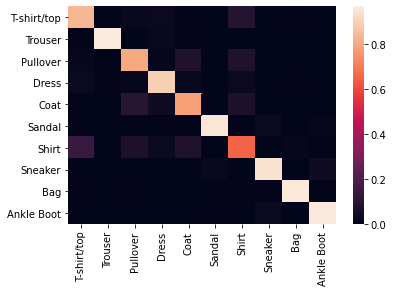

In [200]:
cmat = confusion_matrix(trueLabels, predLabels, normalize = 'true')
sn.heatmap(cmat,yticklabels = classes, xticklabels = classes)

print(classification_report(trueLabels, predLabels, target_names = classes))


88% accuracy, not bad. Probably some room for improvement. I see that shirts are often confused for coats, pullovers, and t-shirt/tops, which seems like it would be hard for some humans to differentiate between